In [1]:
import torch.nn as nn
import torch
import pandas as pd
import pathlib
import numpy as np
import time
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyper parameters
epoch = 10  # epoch
barch_size = 64  # batch size for training
LR = 5  # learning rate

batch_size = 64

In [2]:
'''
1. Access to the raw dataset iterators
'''
from torch.utils.data import DataLoader
from torchtext.datasets import AG_NEWS

train_dataset, test_dataset  = AG_NEWS()

target_classes = ["World", "Sports", "Business", "Sci/Tec"]

In [3]:
'''
2. Prepare data
'''
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train_dataset, test_dataset]), specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [4]:
len(vocab.get_itos())

98635

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from torchtext.data.functional import to_map_style_dataset

vectorizer = CountVectorizer(vocabulary=vocab.get_itos(), tokenizer=tokenizer)

def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = vectorizer.transform(X).todense()
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y)

train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=32, collate_fn=vectorize_batch)

In [6]:
for t in train_dataset:
    print(t)
    break
print()

for text, label in train_loader:
    print(label.shape, text.shape)
    break

(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

torch.Size([32]) torch.Size([32, 98635])


In [7]:
'''
3. Define the model
'''

from torch.nn import functional as F

class TextClassifier(nn.Module):
    def __init__(self):
        super(TextClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(len(vocab), 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 4),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)


In [8]:
# test output dimension
text_classifier = TextClassifier()
for X, Y in train_loader:
    Y_preds = text_classifier(X)
    print(Y_preds.shape)
    break

torch.Size([32, 4])


In [9]:
'''
4. Train the model
'''

from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)


In [44]:
from torch.optim import Adam

epochs = 8
learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss()
text_classifier = TextClassifier()
optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

TrainModel(text_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

 15%|█▍        | 11/75 [00:03<00:23,  2.75it/s]


KeyboardInterrupt: 

In [40]:
"""
5. save model
"""
torch.save(text_classifier.state_dict(),"./text_classifier.pth")

In [8]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(text_classifier, test_loader)

NameError: name 'text_classifier' is not defined

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Test Accuracy : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nClassification Report : ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_actual, Y_preds))

Test Accuracy : 0.81625

Classification Report : 
              precision    recall  f1-score   support

       World       0.81      0.87      0.84       616
      Sports       0.94      0.85      0.89       617
    Business       0.88      0.61      0.72       545
     Sci/Tec       0.71      0.92      0.80       622

    accuracy                           0.82      2400
   macro avg       0.83      0.81      0.81      2400
weighted avg       0.83      0.82      0.81      2400


Confusion Matrix : 
[[534  21  15  46]
 [ 45 523   6  43]
 [ 64   9 331 141]
 [ 20   5  26 571]]


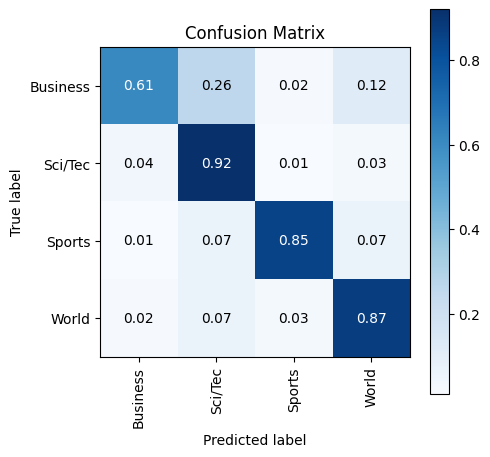

In [25]:


import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Blues",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);

## Using Embedding calculated by DG method

In [30]:

truncate = 2400
train_strings = vectorizer.fit_transform([X for y, X in train_dataset[0:truncate]]).toarray()
test_strings = vectorizer.transform([X for y,X in test_dataset[0:2400]]).toarray()
train_labels = [y for y,X in train_dataset[0:truncate]]
test_labels = [y for y,X in test_dataset[0:2400]]

/home/hty/PycharmProjects/INF580-DG_Word2Vec/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/hty/PycharmProjects/INF580-DG_Word2Vec/venv/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:1379: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [31]:

from sklearn.decomposition import PCA
import time
start_time = time.time()
pca = PCA(n_components=30)
train_vectors = pca.fit_transform(train_strings)
test_vectors = pca.transform(test_strings)
train_vectors.shape, test_vectors.shape, time.time()-start_time

((2400, 30), (2400, 30), 14.131334781646729)

In [45]:
train_vector_dataset = [(train_labels[i], train_vectors[i]) for i in range(truncate)]
test_vector_dataset = [(test_labels[i], test_vectors[i]) for i in range(2400)]


In [46]:
len(train_labels)

2400

In [47]:

def gather_batch(batch):
    Y, X = list(zip(*batch))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y)-1

train_loader = DataLoader(train_vector_dataset, batch_size=128, collate_fn=gather_batch)
test_loader  = DataLoader(test_vector_dataset, batch_size=128, collate_fn=gather_batch)

In [48]:
class DGClassifier(nn.Module):

    def __init__(self, sentence_dim = 128):
        super(DGClassifier, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(sentence_dim, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 4),
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [ ]:
from torch.optim import Adam

epochs = 200
learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss()
text_classifier = DGClassifier(30)
optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

TrainModel(text_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

In [40]:
train_coords = np.load("Realization_2400_30.npy")
test_coords = np.load("Realization_2400_30_test.npy")
test_coords.shape

(2400, 30)

In [50]:
train_coords_dataset = [(train_labels[i], train_coords[i]) for i in range(truncate)]
test_coords_dataset = [(test_labels[i], test_coords[i]) for i in range(2400)]
def gather_batch(batch):
    Y, X = list(zip(*batch))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y) - 1

train_loader = DataLoader(train_coords_dataset, batch_size=128, collate_fn=gather_batch)
test_loader  = DataLoader(test_coords_dataset, batch_size=128, collate_fn=gather_batch)

In [51]:
from torch.optim import Adam

epochs = 200
learning_rate = 1e-4

loss_fn = nn.CrossEntropyLoss()
text_classifier = DGClassifier(30)
optimizer = Adam(text_classifier.parameters(), lr=learning_rate)

TrainModel(text_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 19/19 [00:00<00:00, 887.47it/s]


Train Loss : 179.948
Valid Loss : 4.621
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 669.13it/s]


Train Loss : 135.624
Valid Loss : 4.502
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 1034.68it/s]


Train Loss : 104.352
Valid Loss : 4.342
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 995.43it/s]


Train Loss : 75.254
Valid Loss : 4.177
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 1027.96it/s]


Train Loss : 44.480
Valid Loss : 4.017
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 884.88it/s]


Train Loss : 14.279
Valid Loss : 3.895
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 790.24it/s]


Train Loss : 4.132
Valid Loss : 3.906
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 1059.13it/s]


Train Loss : 3.369
Valid Loss : 3.879
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 936.43it/s]


Train Loss : 3.061
Valid Loss : 3.853
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 1048.60it/s]


Train Loss : 2.968
Valid Loss : 3.844
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 1060.93it/s]


Train Loss : 2.885
Valid Loss : 3.828
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 1067.93it/s]


Train Loss : 2.728
Valid Loss : 3.817
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 1014.90it/s]


Train Loss : 2.684
Valid Loss : 3.799
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 869.16it/s]


Train Loss : 2.566
Valid Loss : 3.788
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 664.72it/s]


Train Loss : 2.514
Valid Loss : 3.778
Valid Acc  : 0.257


100%|██████████| 19/19 [00:00<00:00, 897.13it/s]


Train Loss : 2.464
Valid Loss : 3.768
Valid Acc  : 0.250


100%|██████████| 19/19 [00:00<00:00, 891.62it/s]


Train Loss : 2.438
Valid Loss : 3.762
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 893.24it/s]


Train Loss : 2.412
Valid Loss : 3.753
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 875.52it/s]


Train Loss : 2.356
Valid Loss : 3.744
Valid Acc  : 0.253


100%|██████████| 19/19 [00:00<00:00, 906.82it/s]


Train Loss : 2.313
Valid Loss : 3.740
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 900.60it/s]


Train Loss : 2.299
Valid Loss : 3.733
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 930.42it/s]


Train Loss : 2.247
Valid Loss : 3.727
Valid Acc  : 0.254


100%|██████████| 19/19 [00:00<00:00, 904.17it/s]


Train Loss : 2.202
Valid Loss : 3.720
Valid Acc  : 0.244


100%|██████████| 19/19 [00:00<00:00, 900.49it/s]


Train Loss : 2.196
Valid Loss : 3.714
Valid Acc  : 0.246


100%|██████████| 19/19 [00:00<00:00, 921.35it/s]


Train Loss : 2.195
Valid Loss : 3.708
Valid Acc  : 0.245


100%|██████████| 19/19 [00:00<00:00, 842.76it/s]


Train Loss : 2.193
Valid Loss : 3.702
Valid Acc  : 0.246


100%|██████████| 19/19 [00:00<00:00, 878.18it/s]

Train Loss : 2.189


Valid Loss : 3.696
Valid Acc  : 0.247


100%|██████████| 19/19 [00:00<00:00, 892.21it/s]

Train Loss : 2.185


Valid Loss : 3.690
Valid Acc  : 0.249


100%|██████████| 19/19 [00:00<00:00, 726.39it/s]


Train Loss : 2.181
Valid Loss : 3.684
Valid Acc  : 0.250


100%|██████████| 19/19 [00:00<00:00, 673.70it/s]


Train Loss : 2.178
Valid Loss : 3.678
Valid Acc  : 0.250


100%|██████████| 19/19 [00:00<00:00, 904.78it/s]


Train Loss : 2.174
Valid Loss : 3.672
Valid Acc  : 0.250


100%|██████████| 19/19 [00:00<00:00, 899.68it/s]


Train Loss : 2.170
Valid Loss : 3.666
Valid Acc  : 0.251


100%|██████████| 19/19 [00:00<00:00, 829.59it/s]


Train Loss : 2.166
Valid Loss : 3.660
Valid Acc  : 0.252


100%|██████████| 19/19 [00:00<00:00, 892.56it/s]


Train Loss : 2.163
Valid Loss : 3.654
Valid Acc  : 0.253


100%|██████████| 19/19 [00:00<00:00, 889.86it/s]


Train Loss : 2.159
Valid Loss : 3.648
Valid Acc  : 0.252


100%|██████████| 19/19 [00:00<00:00, 908.44it/s]


Train Loss : 2.155
Valid Loss : 3.643
Valid Acc  : 0.252


100%|██████████| 19/19 [00:00<00:00, 1018.66it/s]


Train Loss : 2.151
Valid Loss : 3.637
Valid Acc  : 0.252


100%|██████████| 19/19 [00:00<00:00, 896.86it/s]


Train Loss : 2.147
Valid Loss : 3.631
Valid Acc  : 0.253


100%|██████████| 19/19 [00:00<00:00, 906.14it/s]


Train Loss : 2.143
Valid Loss : 3.625
Valid Acc  : 0.253


100%|██████████| 19/19 [00:00<00:00, 899.76it/s]


Train Loss : 2.139
Valid Loss : 3.619
Valid Acc  : 0.254


100%|██████████| 19/19 [00:00<00:00, 993.48it/s]


Train Loss : 2.135
Valid Loss : 3.613
Valid Acc  : 0.254


100%|██████████| 19/19 [00:00<00:00, 1046.76it/s]


Train Loss : 2.130
Valid Loss : 3.607
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 1006.25it/s]


Train Loss : 2.126
Valid Loss : 3.602
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 1022.86it/s]


Train Loss : 2.122
Valid Loss : 3.596
Valid Acc  : 0.255


100%|██████████| 19/19 [00:00<00:00, 1035.40it/s]


Train Loss : 2.117
Valid Loss : 3.590
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 936.97it/s]


Train Loss : 2.113
Valid Loss : 3.584
Valid Acc  : 0.256


100%|██████████| 19/19 [00:00<00:00, 899.09it/s]


Train Loss : 2.108
Valid Loss : 3.578
Valid Acc  : 0.258


100%|██████████| 19/19 [00:00<00:00, 1029.88it/s]


Train Loss : 2.104
Valid Loss : 3.573
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 993.75it/s]


Train Loss : 2.100
Valid Loss : 3.566
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 896.48it/s]


Train Loss : 2.095
Valid Loss : 3.560
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 899.28it/s]


Train Loss : 2.090
Valid Loss : 3.554
Valid Acc  : 0.259


100%|██████████| 19/19 [00:00<00:00, 902.05it/s]


Train Loss : 2.086
Valid Loss : 3.547
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 904.84it/s]


Train Loss : 2.081
Valid Loss : 3.542
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 906.60it/s]


Train Loss : 2.076
Valid Loss : 3.537
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1038.56it/s]


Train Loss : 2.072
Valid Loss : 3.530
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 870.89it/s]


Train Loss : 2.067
Valid Loss : 3.524
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1021.51it/s]


Train Loss : 2.063
Valid Loss : 3.517
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1014.81it/s]


Train Loss : 2.057
Valid Loss : 3.511
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1015.58it/s]


Train Loss : 2.052
Valid Loss : 3.504
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1013.41it/s]


Train Loss : 2.047
Valid Loss : 3.498
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 880.12it/s]


Train Loss : 2.042
Valid Loss : 3.492
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 876.92it/s]


Train Loss : 2.038
Valid Loss : 3.485
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 935.24it/s]


Train Loss : 2.033
Valid Loss : 3.478
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1027.39it/s]


Train Loss : 2.027
Valid Loss : 3.472
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 882.04it/s]


Train Loss : 2.022
Valid Loss : 3.465
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 682.59it/s]


Train Loss : 2.017
Valid Loss : 3.459
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 852.86it/s]


Train Loss : 2.011
Valid Loss : 3.453
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 888.05it/s]


Train Loss : 2.006
Valid Loss : 3.447
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 895.08it/s]


Train Loss : 1.999
Valid Loss : 3.442
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 901.87it/s]


Train Loss : 1.990
Valid Loss : 3.437
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 899.03it/s]


Train Loss : 1.982
Valid Loss : 3.431
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 907.02it/s]


Train Loss : 1.974
Valid Loss : 3.425
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 905.83it/s]


Train Loss : 1.937
Valid Loss : 3.421
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 894.96it/s]


Train Loss : 1.948
Valid Loss : 3.415
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 888.73it/s]


Train Loss : 1.961
Valid Loss : 3.410
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 914.78it/s]


Train Loss : 1.966
Valid Loss : 3.406
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 920.49it/s]


Train Loss : 1.965
Valid Loss : 3.403
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 903.24it/s]


Train Loss : 1.961
Valid Loss : 3.401
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 908.59it/s]


Train Loss : 1.957
Valid Loss : 3.398
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 900.31it/s]


Train Loss : 1.953
Valid Loss : 3.395
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 909.89it/s]


Train Loss : 1.949
Valid Loss : 3.391
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 888.39it/s]


Train Loss : 1.944
Valid Loss : 3.388
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1017.94it/s]


Train Loss : 1.940
Valid Loss : 3.385
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 873.70it/s]


Train Loss : 1.936
Valid Loss : 3.381
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 925.63it/s]


Train Loss : 1.931
Valid Loss : 3.378
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 911.77it/s]


Train Loss : 1.927
Valid Loss : 3.374
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 887.84it/s]


Train Loss : 1.921
Valid Loss : 3.371
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 903.28it/s]


Train Loss : 1.917
Valid Loss : 3.367
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 904.58it/s]

Train Loss : 1.912


Valid Loss : 3.363
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 946.77it/s]


Train Loss : 1.907
Valid Loss : 3.361
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1022.32it/s]


Train Loss : 1.904
Valid Loss : 3.357
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1032.37it/s]


Train Loss : 1.900
Valid Loss : 3.353
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 899.55it/s]


Train Loss : 1.896
Valid Loss : 3.350
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 887.58it/s]


Train Loss : 1.893
Valid Loss : 3.354
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 889.42it/s]


Train Loss : 1.892
Valid Loss : 3.352
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 857.77it/s]


Train Loss : 1.890
Valid Loss : 3.350
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 890.36it/s]


Train Loss : 1.888
Valid Loss : 3.349
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1021.06it/s]


Train Loss : 1.886
Valid Loss : 3.350
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 892.83it/s]


Train Loss : 1.884
Valid Loss : 3.352
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 892.11it/s]


Train Loss : 1.882
Valid Loss : 3.354
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 880.12it/s]


Train Loss : 1.880
Valid Loss : 3.343
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 878.17it/s]


Train Loss : 1.877
Valid Loss : 3.337
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 905.32it/s]


Train Loss : 1.875
Valid Loss : 3.336
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 907.26it/s]


Train Loss : 1.870
Valid Loss : 3.335
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 910.40it/s]


Train Loss : 1.867
Valid Loss : 3.337
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 913.36it/s]


Train Loss : 2.233
Valid Loss : 3.342
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 910.40it/s]


Train Loss : 1.842
Valid Loss : 3.340
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 903.24it/s]


Train Loss : 1.866
Valid Loss : 3.340
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1010.89it/s]


Train Loss : 1.873
Valid Loss : 3.339
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1016.58it/s]


Train Loss : 1.874
Valid Loss : 3.338
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 943.22it/s]


Train Loss : 1.871
Valid Loss : 3.339
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 856.96it/s]


Train Loss : 1.867
Valid Loss : 3.338
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 867.98it/s]


Train Loss : 1.864
Valid Loss : 3.335
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 871.26it/s]


Train Loss : 1.862
Valid Loss : 3.332
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 862.41it/s]


Train Loss : 1.858
Valid Loss : 3.331
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 874.36it/s]


Train Loss : 1.855
Valid Loss : 3.330
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 870.46it/s]


Train Loss : 1.851
Valid Loss : 3.330
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 876.30it/s]


Train Loss : 1.846
Valid Loss : 3.330
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 884.28it/s]


Train Loss : 1.842
Valid Loss : 3.329
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 872.84it/s]

Train Loss : 2.078


Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 860.62it/s]

Train Loss : 1.778


Valid Loss : 3.327
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 865.09it/s]


Train Loss : 1.804
Valid Loss : 3.327
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 884.62it/s]


Train Loss : 1.834
Valid Loss : 3.327
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 774.62it/s]


Train Loss : 1.843
Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 884.02it/s]


Train Loss : 1.839
Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 871.83it/s]

Train Loss : 1.880


Valid Loss : 3.330
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 884.55it/s]

Train Loss : 1.801


Valid Loss : 3.331
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 900.44it/s]


Train Loss : 1.821
Valid Loss : 3.330
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 889.56it/s]


Train Loss : 1.841
Valid Loss : 3.329
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 770.00it/s]


Train Loss : 1.845
Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1041.42it/s]


Train Loss : 1.843
Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1038.34it/s]


Train Loss : 1.842
Valid Loss : 3.327
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 909.03it/s]


Train Loss : 1.839
Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 915.10it/s]


Train Loss : 1.837
Valid Loss : 3.329
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1068.05it/s]


Train Loss : 1.835
Valid Loss : 3.328
Valid Acc  : 0.261


100%|██████████| 19/19 [00:00<00:00, 1026.20it/s]


Train Loss : 1.833
Valid Loss : 3.327
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1044.43it/s]


Train Loss : 1.831
Valid Loss : 3.325
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1022.16it/s]


Train Loss : 1.829
Valid Loss : 3.323
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1017.32it/s]


Train Loss : 1.827
Valid Loss : 3.322
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1002.13it/s]

Train Loss : 1.824


Valid Loss : 3.320
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1030.46it/s]

Train Loss : 1.821


Valid Loss : 3.318
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 892.65it/s]


Train Loss : 1.818
Valid Loss : 3.317
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 872.82it/s]


Train Loss : 1.816
Valid Loss : 3.316
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1024.37it/s]


Train Loss : 1.815
Valid Loss : 3.315
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 900.37it/s]


Train Loss : 1.812
Valid Loss : 3.315
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 888.46it/s]


Train Loss : 1.810
Valid Loss : 3.315
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 906.72it/s]


Train Loss : 1.805
Valid Loss : 3.314
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 901.87it/s]


Train Loss : 1.993
Valid Loss : 3.318
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 908.76it/s]


Train Loss : 1.887
Valid Loss : 3.315
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 943.62it/s]


Train Loss : 1.725
Valid Loss : 3.313
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1047.50it/s]


Train Loss : 1.796
Valid Loss : 3.311
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1004.31it/s]


Train Loss : 1.731
Valid Loss : 3.311
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 897.87it/s]


Train Loss : 1.752
Valid Loss : 3.310
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 990.06it/s]


Train Loss : 1.725
Valid Loss : 3.309
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 643.91it/s]


Train Loss : 1.732
Valid Loss : 3.308
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 876.67it/s]


Train Loss : 1.720
Valid Loss : 3.307
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 856.11it/s]

Train Loss : 1.720


Valid Loss : 3.307
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 963.61it/s]


Train Loss : 1.714
Valid Loss : 3.306
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 885.69it/s]


Train Loss : 1.712
Valid Loss : 3.305
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 907.80it/s]


Train Loss : 1.709
Valid Loss : 3.304
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1010.10it/s]


Train Loss : 1.716
Valid Loss : 3.304
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 996.25it/s]


Train Loss : 1.704
Valid Loss : 3.305
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 902.10it/s]


Train Loss : 1.700
Valid Loss : 3.304
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1055.00it/s]


Train Loss : 1.700
Valid Loss : 3.302
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 890.71it/s]


Train Loss : 1.697
Valid Loss : 3.300
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 896.07it/s]


Train Loss : 1.694
Valid Loss : 3.298
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 808.90it/s]


Train Loss : 1.692
Valid Loss : 3.296
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1066.05it/s]


Train Loss : 1.690
Valid Loss : 3.295
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 901.51it/s]


Train Loss : 1.688
Valid Loss : 3.293
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 888.60it/s]


Train Loss : 1.686
Valid Loss : 3.292
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 878.43it/s]


Train Loss : 1.684
Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 876.50it/s]


Train Loss : 1.682
Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 716.58it/s]

Train Loss : 1.681


Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 889.20it/s]


Train Loss : 1.679
Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 874.80it/s]


Train Loss : 1.678
Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 955.87it/s]


Train Loss : 1.677
Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 884.64it/s]

Train Loss : 1.676


Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 908.40it/s]

Train Loss : 1.674


Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 894.48it/s]


Train Loss : 1.673
Valid Loss : 3.290
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 892.01it/s]


Train Loss : 1.672
Valid Loss : 3.289
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 905.77it/s]


Train Loss : 1.671
Valid Loss : 3.289
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 890.11it/s]


Train Loss : 1.670
Valid Loss : 3.288
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 900.69it/s]


Train Loss : 1.669
Valid Loss : 3.287
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 905.48it/s]


Train Loss : 1.668
Valid Loss : 3.286
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 737.66it/s]

Train Loss : 1.667


Valid Loss : 3.285
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 890.12it/s]

Train Loss : 1.666


Valid Loss : 3.284
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 861.15it/s]

Train Loss : 1.665


Valid Loss : 3.283
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 997.73it/s]

Train Loss : 1.664


Valid Loss : 3.282
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1063.61it/s]


Train Loss : 1.663
Valid Loss : 3.281
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1010.33it/s]


Train Loss : 1.662
Valid Loss : 3.280
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 1014.97it/s]


Train Loss : 1.662
Valid Loss : 3.279
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 880.95it/s]


Train Loss : 1.660
Valid Loss : 3.279
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 887.70it/s]


Train Loss : 1.659
Valid Loss : 3.278
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 853.93it/s]


Train Loss : 1.659
Valid Loss : 3.277
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 884.91it/s]


Train Loss : 1.658
Valid Loss : 3.276
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 889.89it/s]


Train Loss : 1.657
Valid Loss : 3.275
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 880.34it/s]


Train Loss : 1.656
Valid Loss : 3.274
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 868.95it/s]


Train Loss : 1.655
Valid Loss : 3.273
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 889.69it/s]


Train Loss : 1.654
Valid Loss : 3.272
Valid Acc  : 0.260


100%|██████████| 19/19 [00:00<00:00, 859.12it/s]


Train Loss : 1.653
Valid Loss : 3.271
Valid Acc  : 0.260
